# <b>Tomato Plant Disease Detection Model<b>

#### Importing Required Libraries

In [1]:
!pip install tensorflow-model-optimization

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tf-keras

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot


##### Defining all Hyperparameters

##### Defining all Hyperparameters

In [4]:


BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=10

### 

<b>Stage 1: Data Preprocessing and Exploration</b>

In [5]:
!cd

C:\Users\Anshika Gupta\Tomato-Plant-Disease-Detection-Model\disease-prediction


In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "..\\..\\Downloads\\archive\\PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
for image_batch, labels_batch in dataset.take(4):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[0 2 4 6 0 7 9 6 6 7 4 7 1 1 0 7 0 7 0 9 0 5 7 2 1 4 7 9 9 1 2 5]
(32, 128, 128, 3)
[4 5 5 7 1 5 9 7 2 4 7 5 5 0 3 5 4 5 2 3 7 5 7 7 6 0 2 2 0 6 9 6]
(32, 128, 128, 3)
[1 3 2 3 9 6 5 7 1 3 7 0 1 9 9 4 2 0 4 6 5 2 7 4 6 3 8 6 4 3 9 2]
(32, 128, 128, 3)
[0 0 4 7 7 7 7 3 1 2 4 7 9 2 5 0 9 0 4 7 7 2 4 8 0 7 7 4 5 0 6 5]


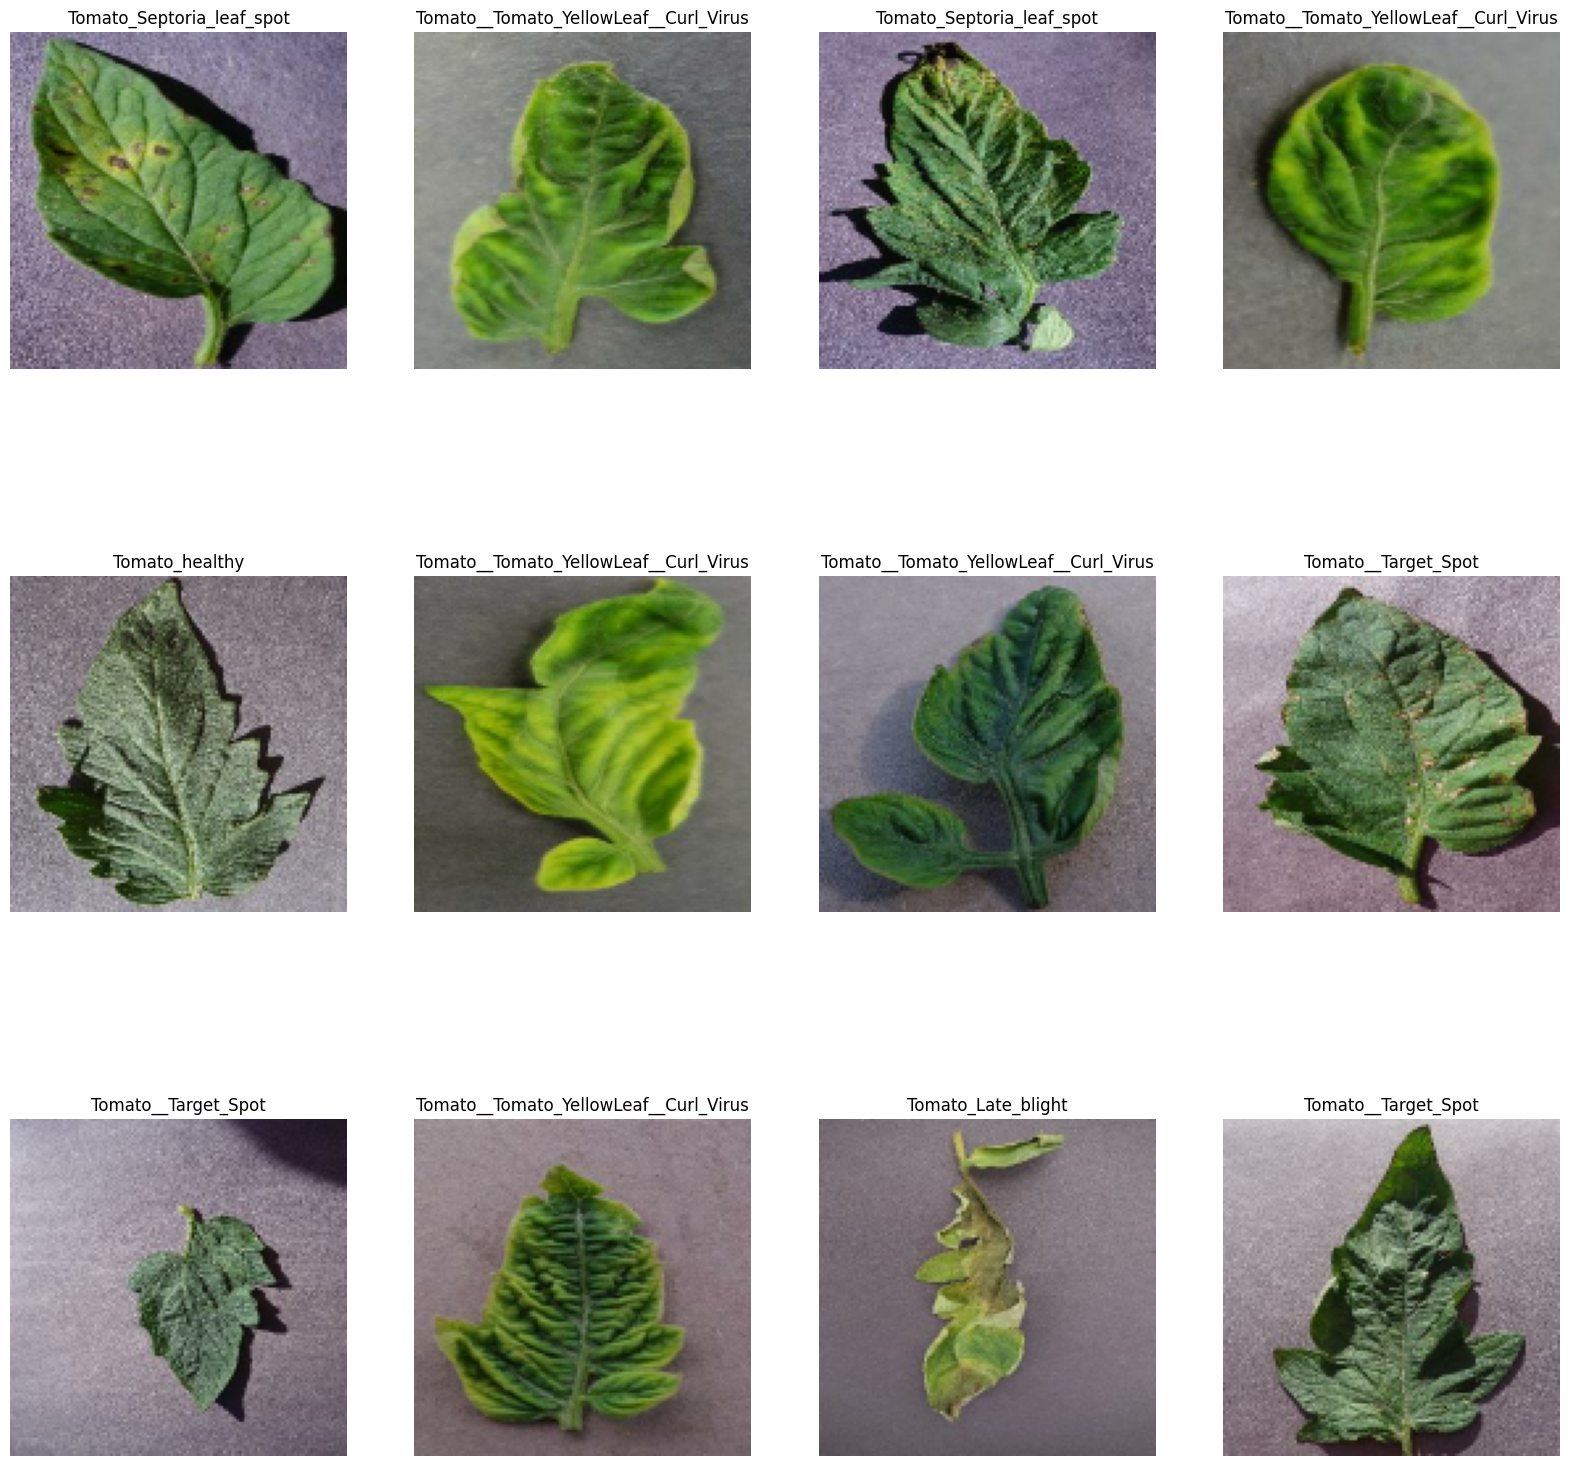

In [9]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

##### <b>Function to Split Dataset</b>
Dataset should be bifurcated into 3 subsets:
<ol>
<li>Training: Dataset to be used while training (60%)</li>
<li>Validation: Dataset to be tested against while training (40%)</li>
<li>Test: Dataset to be tested against after we trained a model (10%)</li>
<ol>

In [10]:
len(dataset)

501

In [11]:
train_size = 0.8
len(dataset)*train_size

400.8

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

447

In [14]:
val_size=0.1
len(dataset)*val_size

50.1

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

441

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, 
            test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

400

In [20]:
len(val_ds)

50

In [21]:
len(test_ds)

51

#### Cache, Shuffle, and Prefetch the Dataset

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Layer for Resizing and Normalization

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

#### Data Augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

### <b>Stage 2: Model Development</b>

#### Model Architecture

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Anshika Gupta\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 128, 128, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 128, 128, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 126, 126, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 63, 63, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 61, 61, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 57600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,706,506 (14.14 MB)

 Trainable params: 3,706,506 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the Model

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 171s 330ms/step - accuracy: 0.4325 - loss: 1.6507 - val_accuracy: 0.7475 - val_loss: 0.7324
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 112s 280ms/step - accuracy: 0.7639 - loss: 0.6780 - val_accuracy: 0.7950 - val_loss: 0.5678
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 92s 229ms/step - accuracy: 0.8180 - loss: 0.5259 - val_accuracy: 0.8075 - val_loss: 0.5662
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 221ms/step - accuracy: 0.8406 - loss: 0.4641 - val_accuracy: 0.8194 - val_loss: 0.4919
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 86s 216ms/step - accuracy: 0.8721 - loss: 0.3662 - val_accuracy: 0.8775 - val_loss: 0.3519
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 90s 226ms/step - accuracy: 0.8812 - loss: 0.3467 - val_accuracy: 0.8750 - val_loss: 0.3576
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 90s 224ms/step - accuracy: 0.8922 - loss: 0.3091 - val_accuracy: 0.8788 - val_loss: 0.3116
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 220ms/step - accuracy: 0.9059 - loss:

In [30]:
scores = model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8870 - loss: 0.3518


In [32]:
scores

[0.32877790927886963, 0.8884803652763367]

#### Plotting the Accuracy and Loss Curves

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

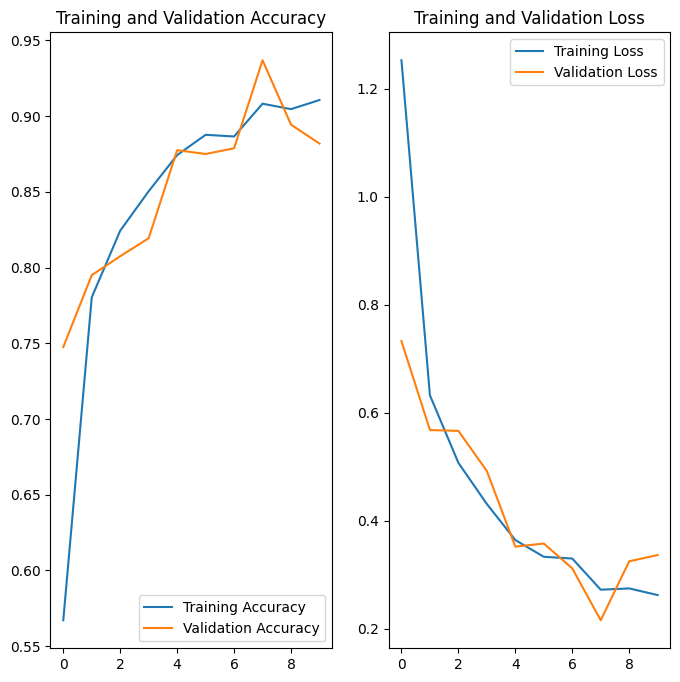

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
import os
os.mkdir("model")

In [36]:
model_version=1
#model_version=max([int(i) for i in os.listdir("model") + [0]])+1
model.save(f"model.h5")


In [37]:
keras_model = "tomato.h5"
model.save(keras_model)

### 
<b>Stage 3: Model Conversion and Deployment</b>

#### Convert saved model to tf lite

In [38]:
tlm = "tf_lite_model.tflite"

In [39]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Anshika Gupta\AppData\Local\Temp\tmpptamf8fp\assets


INFO:tensorflow:Assets written to: C:\Users\Anshika Gupta\AppData\Local\Temp\tmpptamf8fp\assets


Saved artifact at 'C:\Users\Anshika Gupta\AppData\Local\Temp\tmpptamf8fp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(32, 10), dtype=tf.float32, name=None)
Captures:
  2704081791568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2704081792336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2704081790608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2704081790992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2704081793488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2704081792720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2704081792528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2704081794448: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [40]:
tflite_model_name = tlm
open(tflite_model_name, "wb").write(tflite_model)

3716520

In [41]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
input_details

[{'name': 'serving_default_keras_tensor:0',
  'index': 0,
  'shape': array([ 32, 128, 128,   3]),
  'shape_signature': array([ 32, 128, 128,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [43]:
output_details

[{'name': 'StatefulPartitionedCall_1:0',
  'index': 19,
  'shape': array([32, 10]),
  'shape_signature': array([32, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [44]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [47]:
count = 0
for image, label in test_ds.take(5):
    print(label)
    
print(count)

tf.Tensor([7 9 7 2 2 3 5 5 9 7 9 6 7 2 7 6 7 7 2 7 3 0 2 7 2 3 1 9 1 0 5 4], shape=(32,), dtype=int32)
tf.Tensor([5 6 3 9 7 6 0 5 5 3 7 2 1 7 3 0 1 6 7 4 4 7 4 7 5 9 4 0 3 6 9 9], shape=(32,), dtype=int32)
tf.Tensor([0 0 5 7 9 7 7 4 1 4 7 4 4 2 9 1 4 9 9 6 7 9 9 7 7 0 3 6 0 7 6 2], shape=(32,), dtype=int32)
tf.Tensor([2 2 0 9 5 7 6 3 2 0 7 6 4 1 7 0 2 5 7 0 9 9 2 1 7 7 6 0 2 3 9 7], shape=(32,), dtype=int32)
tf.Tensor([2 5 8 3 7 2 3 6 0 7 5 2 5 7 6 7 9 2 3 6 5 0 5 4 4 4 9 3 7 9 1 0], shape=(32,), dtype=int32)
0


In [48]:
for image, label in test_ds.unbatch().take(5):
    print("image shape",image.shape)
    print("label",label)

image shape (128, 128, 3)
label tf.Tensor(7, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(5, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(0, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(0, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(0, shape=(), dtype=int32)


In [49]:
print(test_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [51]:
import numpy as np

batch_images = []
batch_size = 32

for image, label in test_ds.unbatch().take(batch_size):
    batch_images.append(image.numpy().astype(np.float32))

# Convert list to NumPy array and reshape
input_data = np.array(batch_images)  # Shape: (32, height, width, channels)

# Ensure correct shape
print("Input shape:", input_data.shape)

interpreter.set_tensor(input_index, input_data)
interpreter.invoke()
output = interpreter.get_tensor(output_index)
print(output)


Input shape: (32, 128, 128, 3)
[[1.56409424e-05 2.61692185e-06 9.98818099e-01 1.29831868e-04
  2.05740957e-06 3.62704600e-06 9.78875292e-09 6.58925314e-09
  4.38459859e-11 1.02805311e-03]
 [2.49472004e-03 2.95884185e-03 6.60134829e-04 3.42061253e-06
  5.33444945e-05 4.51349536e-08 1.77290058e-10 9.93829429e-01
  2.70792526e-08 3.04428704e-09]
 [7.79768765e-01 2.08631456e-01 2.33234794e-04 1.97600177e-03
  9.41825565e-05 2.02596118e-03 7.81550305e-04 6.48828549e-03
  3.44091292e-12 5.65956896e-07]
 [5.81920631e-07 2.61684050e-07 9.57991375e-09 2.07077328e-10
  8.56791473e-08 8.82233519e-16 2.62328027e-18 9.99999046e-01
  4.33065516e-14 5.60372679e-18]
 [2.32616637e-09 2.00942275e-03 3.15868645e-04 2.52739312e-07
  1.14592957e-08 9.97442961e-01 1.59934658e-04 6.02138534e-05
  5.93340737e-08 1.12674088e-05]
 [1.87690521e-08 6.69764704e-04 3.37753554e-05 5.78332958e-07
  1.59560159e-06 1.10217843e-05 2.22032323e-01 1.58108693e-10
  1.33736560e-08 7.77250946e-01]
 [1.05072581e-03 9.95963156

In [53]:
#for image, label in test_ds.unbatch().take(5):
 #   input_data = np.expand_dims(image.numpy().astype(np.float32), axis=0)
  #  interpreter.set_tensor(input_index, input_data)
   # interpreter.invoke()
    #output = interpreter.get_tensor(output_index)
    #print(output)


In [55]:
#for image, label in test_ds.unbatch().take(5):
    # Add batch dimension
 #   input_data = np.expand_dims(image.numpy().astype(np.float32), axis=0)  # Shape: (1, height, width, channels)
    
  #  interpreter.set_tensor(input_index, input_data)
   # interpreter.invoke()

    #output = interpreter.get_tensor(output_index)
    #print(output)


In [56]:
#for image, label in test_ds.unbatch().take(5):
 #   interpreter.set_tensor(input_index, [image.numpy().astype(np.float32)])
  #  interpreter.invoke()
#
 #   output = interpreter.get_tensor(output_index)

In [57]:
import numpy as np

predicted_labels = []
actual_labels = []

for image, label in test_ds.unbatch():
    # Convert single image to NumPy and ensure it's float32
    input_tensor = np.expand_dims(image.numpy(), axis=0).astype(np.float32)  # Shape (1, 128, 128, 3)

    # Repeat the image to create a batch of 32
    input_tensor = np.tile(input_tensor, (32, 1, 1, 1))  # Shape (32, 128, 128, 3)

    interpreter.set_tensor(input_index, input_tensor)
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)

    predicted_labels.append(np.argmax(output[0]))  # Get the first prediction
    actual_labels.append(label.numpy())  # Store actual label

print(predicted_labels, actual_labels)


[7, 3, 3, 9, 7, 2, 8, 3, 7, 0, 4, 6, 7, 3, 4, 1, 1, 5, 3, 6, 4, 0, 7, 5, 1, 4, 4, 9, 9, 5, 3, 9, 7, 0, 5, 0, 4, 7, 7, 3, 6, 7, 4, 7, 0, 4, 0, 5, 0, 7, 2, 9, 0, 4, 5, 7, 7, 5, 2, 2, 7, 7, 7, 7, 7, 9, 7, 3, 3, 7, 6, 9, 3, 7, 5, 7, 7, 2, 7, 5, 7, 9, 0, 8, 5, 5, 3, 3, 0, 1, 9, 7, 2, 0, 7, 6, 1, 2, 5, 0, 0, 2, 5, 7, 5, 0, 4, 1, 7, 4, 8, 9, 5, 1, 7, 0, 7, 0, 6, 0, 2, 7, 7, 5, 0, 9, 9, 7, 1, 2, 7, 1, 7, 7, 9, 9, 4, 9, 7, 4, 7, 0, 0, 7, 8, 7, 7, 7, 0, 7, 0, 5, 7, 5, 0, 1, 5, 7, 9, 7, 0, 1, 0, 2, 7, 9, 3, 5, 2, 4, 1, 2, 2, 0, 1, 1, 4, 0, 7, 9, 5, 4, 7, 2, 2, 3, 7, 5, 7, 4, 7, 0, 2, 7, 0, 7, 5, 9, 1, 5, 7, 7, 1, 3, 1, 7, 4, 3, 0, 2, 7, 5, 9, 2, 6, 7, 6, 1, 5, 6, 1, 1, 4, 2, 5, 6, 3, 9, 7, 5, 1, 5, 5, 3, 7, 2, 1, 7, 3, 0, 2, 6, 7, 4, 4, 7, 4, 5, 5, 9, 4, 0, 3, 6, 9, 9, 4, 1, 0, 5, 8, 9, 9, 9, 0, 1, 7, 2, 4, 4, 9, 7, 0, 2, 2, 7, 6, 9, 7, 7, 7, 1, 1, 1, 7, 0, 0, 0, 0, 9, 4, 0, 3, 2, 7, 2, 5, 2, 5, 0, 7, 9, 2, 9, 9, 2, 4, 9, 7, 3, 0, 9, 7, 1, 6, 2, 9, 1, 5, 5, 9, 9, 0, 3, 4, 1, 3, 5, 1, 2, 4, 9, 5, 

In [58]:
#predicted_labels = []
#actual_labels = []

#for image, label in test_ds.unbatch():
#    interpreter.set_tensor(input_index, [image])
#    interpreter.invoke()
#
 #   output = interpreter.get_tensor(output_index)
  #  predicted_labels.append(np.argmax(output[0]))
  #  actual_labels.append(label.numpy())

In [59]:
predicted_labels[:10]

[7, 3, 3, 9, 7, 2, 8, 3, 7, 0]

In [60]:
actual_labels[:10]

[7, 3, 3, 9, 7, 2, 8, 3, 7, 0]

In [61]:
comparison_vector = np.array(predicted_labels) == np.array(actual_labels)
comparison_vector[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [62]:
np.array([True,False,True]).mean()

0.6666666666666666

In [63]:
accuracy = comparison_vector.mean()
accuracy

0.8878676470588235

#### Quantization Aware Model

In [64]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [66]:
#annotated_model = tf.keras.models.clone_model(
 #   model,
  #  clone_function=apply_quantization,
#)

#quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
#quant_aware_model.summary()

In [ ]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

In [ ]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

In [ ]:
tlqm = "tf_lite_quantized_model.tflite"

In [ ]:
tf_lite_quantized_model = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
tf_lite_quantized_model.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_quantized_model.target_spec.supported_types = [tf.float16]
quantized_tflite_model = tf_lite_quantized_model.convert()

In [ ]:
tf_lite_quantized_model = tlqm
open(tf_lite_quantized_model, "wb").write(quantized_tflite_model)

In [ ]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

### <b>Stage 4 : Evaluation and Validation</b>

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n 
                  Confidence: {confidence}%")
        plt.axis("off")